
**참고자료**
<br>
<br>
 * https://somjang.tistory.com/entry/Keras%EA%B8%B0%EC%82%AC-%EC%A0%9C%EB%AA%A9%EC%9D%84-%EA%B0%80%EC%A7%80%EA%B3%A0-%EA%B8%8D%EC%A0%95-%EB%B6%80%EC%A0%95-%EC%A4%91%EB%A6%BD-%EB%B6%84%EB%A5%98%ED%95%98%EB%8A%94-%EB%AA%A8%EB%8D%B8-%EB%A7%8C%EB%93%A4%EC%96%B4%EB%B3%B4%EA%B8%B0
<br>
<br>
 * https://github.com/sbomhoo/naver_news_crawling/blob/master/README.md

# 뉴스 기사 이슈분석 지표 (WordCloud)

## 데이터 불러오기
<br>

**데이터 특성 정의( 각각의 데이터가 어떤 특성을 가지는지? )**

    ▶ date : 등록된 기사별 날짜
    ▶ title : 기사 제목
    ▶ source : 언론사
    ▶ contents : 기사 내용 요약본
    ▶ link : 사이트 주소

※ : 네이버 뉴스 기준으로 Test... ( 구글 뉴스데이터와 병합해서 전처리 실시 예정 )

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import datetime, time
import re
import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [143]:
# 시각화 글자 깨짐 방지
import os

if os.name == 'posix':
    plt.rc("font", family="AppleGothic")
else:
    plt.rc("font", family="Malgun Gothic")

In [3]:
matplotlib.rc('font',family='NanumGothic')

# 한글 폰트 적용
matplotlib.rc('axes', unicode_minus = False) # True

# 2022 / 04 / 21 일자 스크래핑 데이터
df_news = pd.read_csv('./news_data.csv', engine= 'python',encoding = 'utf-8')

# (행, 열)
print(df_news.shape)
df_news.head(1)

(651, 1024)


,Unnamed: 0,date,title,source,contents,link,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 1014,Unnamed: 1015,Unnamed: 1016,Unnamed: 1017,Unnamed: 1018,Unnamed: 1019,Unnamed: 1020,Unnamed: 1021,Unnamed: 1022,Unnamed: 1023
0,0,2022.04.01.,"대구은행, 기업경영개선 전문역·경영컨설턴트 모집",미디어펜,DGB대구은행는 오는 4일부터 15일까지 '기업경영개선 전문역'과 '경영컨설턴트'를...,http://www.mediapen.com/news/view/713090,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# 데이터 구조 파악시 용이
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651 entries, 0 to 650
Columns: 1024 entries, Unnamed: 0 to Unnamed: 1023
dtypes: float64(169), int64(1), object(854)
memory usage: 5.1+ MB


# 데이터 전처리

## 이상치와 결측치 제거 / 데이터 특성(구조) 확인
    ▶ 필요없는 컬럼 제거
    ▶ 컬럼명과 순서 변경 
    ▶ 데이터 구조 파악 - info, head
    
    ▶ 우선 'DGB대구은행'과 필요없는 언론사는 버리고 인덱스번호도 초기화 시켜야 함.
    예를 들면, 축구관련 기사

    제목과 요약본 기준
    '감독' / '신태용' / 'DGB대구은행파크' / '대표팀' / '경기' / '스포츠' / '축구'
    참고 사이트 : https://jimmy-ai.tistory.com/92
※ : 수치별 데이터가 아니므로 이상치는 굳이 확인할 필요가 없다고 판단

In [6]:
# 필요한 데이터만 추출
df_news = df_news.loc[:,['date', 'title', 'source', 'contents']]

# 컬럼명 변경
df_news.rename(columns={'source' : 'press'}, inplace=True)

In [7]:
df_news.head(1)

,date,title,press,contents
0,2022.04.01.,"대구은행, 기업경영개선 전문역·경영컨설턴트 모집",미디어펜,DGB대구은행는 오는 4일부터 15일까지 '기업경영개선 전문역'과 '경영컨설턴트'를...


In [8]:
# 행별로 null값 존재 유무 파악 --> 결측치 없음.
df_news.isnull().sum(axis = 0)

date        0
title       0
press       0
contents    0
dtype: int64

In [25]:
# 중복행 제거 --> 분석하는데 안 좋을 수도 있으니 신중한 고려가 필요함.
# 참고 : https://sy-log.tistory.com/60

print(df_news.shape)
print(df_news.duplicated().sum())

# 651 --> 269로 줄어듬.
df_news.drop_duplicates().head(3)

(651, 4)
269


,date,title,press,contents
0,2022.04.01.,"대구은행, 기업경영개선 전문역·경영컨설턴트 모집",미디어펜,DGB대구은행는 오는 4일부터 15일까지 '기업경영개선 전문역'과 '경영컨설턴트'를...
1,2022.04.01.,"DGB대구은행, 기업개선경영 전문역·경영컨설턴트 모집",아이뉴스24,DGB대구은행이 오는 4일부터 15일까지 '기업경영개선 전문역' 과 '경영컨설턴트'...
2,2022.04.01.,"대구은행, 기업경영개선 전문역·경영컨설턴트 모집",데일리안,DGB대구은행은 1일 ‘기업경영개선 전문역’과 ‘경영컨설턴트’를 공개 채용한다고 밝...


In [30]:
# AND용
# target_string = ['서울', '마포']
# df[df['주소'].map(lambda x: all(string in x for string in target_string))]

In [31]:
# df.query('주소.str.contains("마포|은평")', engine='python'
# Series 내장함수 : str.contains() 

# 제목
remove_title = list(df_news.query('title.str.contains("감독|신태용|대표팀|친선경기|스포츠|축구")', engine = 'python').index)
df_news.drop(remove_title, axis=0, inplace = True)

# 내용 요약본
remove_contents = list(df_news.query('contents.str.contains("감독|신태용|대표팀|친선경기|스포츠|축구")', engine = 'python').index)
df_news.drop(remove_contents, axis=0, inplace = True)


In [32]:
df_news.shape

(334, 4)

In [33]:
# 인덱스 번호 새로 부여.
df_news.reset_index(inplace=True)
df_news.drop(['index'], axis=1, inplace=True)

In [34]:
df_news.tail(5)

,date,title,press,contents
329,2022.04.11.,"DGB-코리아세븐, '금융채널 혁신 및 리테일 신사업 추진' 업무 협약",지이코노미,2분기中 은행x편의점 복합 점포 선보일 것… 온·오프라인 다양한 협업 시너지 기대 ...
330,2022.04.11.,"DGB금융그룹, 경북도청에 산불 피해 성금 5억 전달",뉴데일리,이번 성금은 지난달 경북 울진과 강원 동해안에서 발생한 대형 산불로 피해 입은 이재...
331,2022.04.11.,"세븐일레븐, DGB대구은행과 맞손...상반기 내 은행 안 편의점 연다",퍼블릭뉴스,손승현 세븐일레븐 금융서비스부문장(좌)과 장문석 대구은행 경영기획본부장(우) [사진...
332,2022.04.11.,"세븐일레븐, DGB대구은행과 금융채널 혁신∙리테일 신사업 추진 MOU 체결",더퍼스트,사진=세븐일레븐 편의점 세븐일레븐은 지난 8일 DGB대구은행과 '금융채널 혁신 및 ...
333,21시간 전,주담대는 은행서만 받는 게 아니다…보험사까지 판 커지는 '담비',블로터언론사 선정,"1금융권인 DGB대구은행, 저축은행업계 1위 SBI저축은행에 이어 BNK부산은행, ..."


## 날짜 데이터 정제
    ▶ 연월일로만 표현 ( 시간 제거 )
    ▶ 연 / 월 / 일 3개의 파생변수 생성
    ▶ 연 / 일 보다는 월별로 각 언론사의 'DGB대구은행'에 관련된 기사가 얼마나 많은지? 파악하기 위함. --> 긍정 / 부정 개수로 이어짐.

In [35]:
# 연도별 월별 일별로 
df_news['date']

0      2022.04.01.
1      2022.04.01.
2      2022.04.01.
3      2022.04.01.
4      2022.04.01.
          ...     
329    2022.04.11.
330    2022.04.11.
331    2022.04.11.
332    2022.04.11.
333         21시간 전
Name: date, Length: 334, dtype: object

In [36]:
now = time.localtime()

# 테스트 용 / 참고 - https://wikidocs.net/104836
print(datetime.datetime.now())
print('{}년 {}월 {}일'.format(now.tm_year, now.tm_mon, now.tm_mday-1))
print(pd.to_datetime(df_news['date'][0]) - datetime.timedelta(days = 6))

2022-05-04 09:20:50.074741
2022년 5월 3일
2022-03-26 00:00:00


In [37]:
# 2022-04-21 17:45 일자 데이터 자료 ( 시각은 무시 )
scrapping_date = datetime.date(2022, 4, 21)

idx_list = list()

for i in range(len(df_news['date'])):
    if '일' in df_news['date'][i]:
        idx_list.append(i)
    elif '시간' in df_news['date'][i]:
        idx_list.append(i)
# df_news['date'][i]
# 몇 일전 / 몇 시간전 인덱스 번호

In [38]:
# 시간 전 / 몇일 전 --> 숫자로 변환

for i in idx_list:
    # '\d+'은 정수만 추출
    trans_day = int(re.findall('\d+', df_news['date'][i])[0]) 
    # 시간 전은 -1일로 통일?
    if '시간' in df_news['date'][i]:
        df_news['date'][i] = scrapping_date - datetime.timedelta(days=1)
    else:
        df_news['date'][i] = scrapping_date - datetime.timedelta(days=trans_day)

In [39]:
df_news['date'] = pd.to_datetime(df_news['date'])

In [40]:
df_news['year'] = df_news['date'].dt.year
df_news['month'] = df_news['date'].dt.month
df_news['day'] = df_news['date'].dt.day

In [41]:
df_news.head(1)

,date,title,press,contents,year,month,day
0,2022-04-01,"대구은행, 기업경영개선 전문역·경영컨설턴트 모집",미디어펜,DGB대구은행는 오는 4일부터 15일까지 '기업경영개선 전문역'과 '경영컨설턴트'를...,2022,4,1


In [200]:
# 데이터 자료 시간에서 마이너스해주면 날짜가 나옴.
# 이것을 다시 대입해주면 날짜 데이터 정제 완료

# 컬럼 제거 axis = 1 --> 열 / axis = 0 --> 행
# df_news.drop(['date_day'], axis=1, inplace=True)

In [42]:
# 참고 : https://hogni.tistory.com/51
# 컬럼 순서 정렬
df_news = df_news[['date', 'year', 'month', 'day', 'title', 'press', 'contents']]

In [43]:
df_news.head()

,date,year,month,day,title,press,contents
0,2022-04-01,2022,4,1,"대구은행, 기업경영개선 전문역·경영컨설턴트 모집",미디어펜,DGB대구은행는 오는 4일부터 15일까지 '기업경영개선 전문역'과 '경영컨설턴트'를...
1,2022-04-01,2022,4,1,"DGB대구은행, 기업개선경영 전문역·경영컨설턴트 모집",아이뉴스24,DGB대구은행이 오는 4일부터 15일까지 '기업경영개선 전문역' 과 '경영컨설턴트'...
2,2022-04-01,2022,4,1,"대구은행, 기업경영개선 전문역·경영컨설턴트 모집",데일리안,DGB대구은행은 1일 ‘기업경영개선 전문역’과 ‘경영컨설턴트’를 공개 채용한다고 밝...
3,2022-04-01,2022,4,1,"DGB대구은행, 기업경영개선 전문역(PCM)·경영컨설턴트 모집",CNB뉴스,"▲ CNB,씨앤비,시앤비,CNB뉴스,씨앤비뉴스 DGB대구은행(은행장 임성훈)는 오는..."
4,2022-04-01,2022,4,1,"DGB대구은행, 기업경영개선 전문역·경영컨설턴트 모집",NSP통신,"최병수 기자, DGB대구은행(139130)는 오는 4일부터 15일까지 ‘기업경영개선..."


# 형태소 분석

    ▶ 혼자 자립해서 쓸 수 있는 말이 바로 ‘단어’ 이고, 단어를 더 쪼갠 것을 ‘형태소’
    
    ▶ 언론사를 각 숫자로 표현 후 EDA 실시 Ex) 1 : 미디어펜, 2 : 아이뉴스24, 3 : 데일리안 ...
    
    ▶ date : 등록된 기사별 날짜
    
**참고사이트 : https://mr-doosun.tistory.com/22 / https://konlpy.org/ko/v0.4.3/morph/**

In [44]:
df_news.head()

,date,year,month,day,title,press,contents
0,2022-04-01,2022,4,1,"대구은행, 기업경영개선 전문역·경영컨설턴트 모집",미디어펜,DGB대구은행는 오는 4일부터 15일까지 '기업경영개선 전문역'과 '경영컨설턴트'를...
1,2022-04-01,2022,4,1,"DGB대구은행, 기업개선경영 전문역·경영컨설턴트 모집",아이뉴스24,DGB대구은행이 오는 4일부터 15일까지 '기업경영개선 전문역' 과 '경영컨설턴트'...
2,2022-04-01,2022,4,1,"대구은행, 기업경영개선 전문역·경영컨설턴트 모집",데일리안,DGB대구은행은 1일 ‘기업경영개선 전문역’과 ‘경영컨설턴트’를 공개 채용한다고 밝...
3,2022-04-01,2022,4,1,"DGB대구은행, 기업경영개선 전문역(PCM)·경영컨설턴트 모집",CNB뉴스,"▲ CNB,씨앤비,시앤비,CNB뉴스,씨앤비뉴스 DGB대구은행(은행장 임성훈)는 오는..."
4,2022-04-01,2022,4,1,"DGB대구은행, 기업경영개선 전문역·경영컨설턴트 모집",NSP통신,"최병수 기자, DGB대구은행(139130)는 오는 4일부터 15일까지 ‘기업경영개선..."


## 정규식 표현

<br>

**'[-=+,#/\?:^$.@*\"※%~&ㆍ\‘\’\_, ②外∙·!』『\(\)\[\]\[\]\<\>\'\`<\>\銀…\"\'…》]' 등을 기사제목에서 제거**
- tqdm --> 진행률 표시 모듈
<br>

In [45]:
from tqdm import tqdm
labels = []

# 원본 데이터프레임 복사하여 사용

df_news_copy = df_news.copy()
title_data = df_news_copy['title'].tolist()

for i in range(len(title_data)):
    clean_title = re.sub('[-=+,#/\?:^$.@*\"※%~&ㆍ\‘\’\_, ②外∙·!』『\(\)\[\]\[\]\<\>\'\`<\>\銀…\"\'…》→p”“◇證‧]', ' ', title_data[i])
    df_news_copy.replace({'title':title_data[i]}, clean_title, inplace=True)

df_news_copy.loc[:5,['title']]

,title
0,대구은행 기업경영개선 전문역 경영컨설턴트 모집
1,DGB대구은행 기업개선경영 전문역 경영컨설턴트 모집
2,대구은행 기업경영개선 전문역 경영컨설턴트 모집
3,DGB대구은행 기업경영개선 전문역 PCM 경영컨설턴트 모집
4,DGB대구은행 기업경영개선 전문역 경영컨설턴트 모집
5,DGB대구은행 기업경영개선 전문역 경영 컨설턴트 모집


## 형태소 분석기 선택 및 처리

<br>

**Hannanum / Kkma / Komoran / Mecab / Twitter(Okt, 사용?)**
- stem = True --> 동사의 원형을 찾아줌.
- norm = True --> 문장의 정규화 여부를 정하는 옵션
<br>

**참고사이트 : https://konlpy.org/ko/v0.4.3/morph/, https://too-march.tistory.com/15**

In [46]:
stopwords = ['의', '가', '이', '은', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']

In [47]:
import konlpy
from konlpy.tag import Okt
okt = Okt()
X_train = []
for sentence in df_news_copy['title']:
    tmp_X = okt.morphs(sentence, stem=True) # 토큰화
    tmp_X = [word for word in tmp_X if not word in stopwords] # 불용어 제거
    # 대기
    # X_train.append(tmp_X)
    df_news_copy.replace({'title':sentence}, ' '.join(tmp_X), inplace=True) # 공백 기준으로 단어 나누기.

In [48]:
df_news_copy.head(3)

,date,year,month,day,title,press,contents
0,2022-04-01,2022,4,1,대구 은행 기업 경영 개선 전문 역 경영 컨설턴트 모집,미디어펜,DGB대구은행는 오는 4일부터 15일까지 '기업경영개선 전문역'과 '경영컨설턴트'를...
1,2022-04-01,2022,4,1,DGB 대구 은행 기업 개선 경영 전문 역 경영 컨설턴트 모집,아이뉴스24,DGB대구은행이 오는 4일부터 15일까지 '기업경영개선 전문역' 과 '경영컨설턴트'...
2,2022-04-01,2022,4,1,대구 은행 기업 경영 개선 전문 역 경영 컨설턴트 모집,데일리안,DGB대구은행은 1일 ‘기업경영개선 전문역’과 ‘경영컨설턴트’를 공개 채용한다고 밝...


In [88]:
print(df_news_copy.loc[:5, ['title']])
# title 컬럼 --> 공백을 기준으로 나눠 리스트로 변환
title_text = ''
for title_words in df_news_copy['title']:
     # 기사 제목당 단어별 리스트 반환
    # print(list(title_words.split(' ')))
    
    # 워드 클라우드를 위한 단어 병합
    title_text += ' '.join(title_words.split(' '))

                                    title
0          대구 은행 기업 경영 개선 전문 역 경영 컨설턴트 모집
1      DGB 대구 은행 기업 개선 경영 전문 역 경영 컨설턴트 모집
2          대구 은행 기업 경영 개선 전문 역 경영 컨설턴트 모집
3  DGB 대구 은행 기업 경영 개선 전문 역 PCM 경영 컨설턴트 모집
4      DGB 대구 은행 기업 경영 개선 전문 역 경영 컨설턴트 모집
5      DGB 대구 은행 기업 경영 개선 전문 역 경영 컨설턴트 모집


## 단어 추출 기준
**2가지 기준**
- 글자 길이가 2 이상인 단어
- 빈도수가 10 이상인 단어

In [92]:
# 명사만 추출 - 글자 길이가 2 이상인 단어만 추출
tokens_ko = okt.nouns(title_text) 
tokens_ko = [ ko for ko in tokens_ko if len(ko) > 1 ]
tokens_ko

['대구',
 '은행',
 '기업',
 '경영',
 '개선',
 '전문',
 '경영',
 '컨설턴트',
 '모집',
 '대구',
 '은행',
 '기업',
 '개선',
 '경영',
 '전문',
 '경영',
 '컨설턴트',
 '모집',
 '대구',
 '은행',
 '기업',
 '경영',
 '개선',
 '전문',
 '경영',
 '컨설턴트',
 '모집',
 '대구',
 '은행',
 '기업',
 '경영',
 '개선',
 '전문',
 '경영',
 '컨설턴트',
 '모집',
 '대구',
 '은행',
 '기업',
 '경영',
 '개선',
 '전문',
 '경영',
 '컨설턴트',
 '모집',
 '대구',
 '은행',
 '기업',
 '경영',
 '개선',
 '전문',
 '경영',
 '컨설턴트',
 '모집',
 '대구',
 '은행',
 '기업',
 '경영',
 '개선',
 '전문',
 '경영',
 '컨설턴트',
 '모집',
 '대한민국',
 '잡스',
 '대구',
 '은행',
 '기업',
 '경영',
 '개선',
 '전문',
 '경영',
 '컨설턴트',
 '모집',
 '대구',
 '은행',
 '기업',
 '개선',
 '경영',
 '컨설턴트',
 '모집',
 '대구',
 '은행',
 '기업',
 '경영',
 '개선',
 '전문',
 '경영',
 '컨설턴트',
 '모집',
 '대구',
 '은행',
 '경영',
 '개선',
 '전문',
 '컨설턴트',
 '공개',
 '채용',
 '임성훈',
 '은행',
 '기업',
 '경영',
 '개선',
 '전문',
 '경영',
 '컨설턴트',
 '공개',
 '채용',
 '대구',
 '은행',
 '기업',
 '개선',
 '경영',
 '컨설턴트',
 '공개',
 '채용',
 '대구',
 '은행',
 '기업',
 '경영',
 '개선',
 '전문',
 '경영',
 '컨설턴트',
 '공채',
 '진행',
 '대구',
 '은행',
 '기업',
 '경영',
 '개선',
 '전문',
 '경영',
 '컨설턴트',
 '모집',
 '대구',
 '은행',
 '기업',
 

In [135]:
# nltk
ko = nltk.Text(tokens_ko, name='대구맛집')
words_cnt = ko.vocab().most_common()
print('단어의 총 갯수 : {}'.format(len(words_cnt)))

# 카운트가 10 이상인 단어만 추출
def select_word(ko_vocab):
    for idx in range(len(ko_vocab)):
        for j in ko_vocab[idx][1:]:
            if j < 10:
                print(idx)
                return idx

idx = select_word(words_cnt)
ko.vocab().most_common(idx)

단어의 총 갯수 : 360
43


[('은행', 273),
 ('대구', 207),
 ('대출', 112),
 ('전세', 93),
 ('금리', 82),
 ('경영', 68),
 ('인하', 66),
 ('제한', 66),
 ('금융', 64),
 ('취급', 62),
 ('해제', 62),
 ('개선', 37),
 ('컨설턴트', 36),
 ('출시', 35),
 ('기업', 34),
 ('전문', 34),
 ('파킹', 31),
 ('통장', 31),
 ('비상', 31),
 ('박스', 31),
 ('모집', 28),
 ('지방', 28),
 ('채용', 25),
 ('편의점', 25),
 ('디지털', 21),
 ('그룹', 20),
 ('혁신', 19),
 ('에너지', 19),
 ('일기', 19),
 ('공모전', 19),
 ('업무', 19),
 ('자금', 18),
 ('점포', 18),
 ('재테크', 18),
 ('세븐일레븐', 18),
 ('협약', 17),
 ('소액', 16),
 ('전국', 16),
 ('채널', 16),
 ('경력', 15),
 ('세대', 15),
 ('특화', 15),
 ('코리아세븐', 15)]

# 워드클라우드 시각화
- 기사 제목을 기준으로 수행 / 명사만 사용.

In [90]:
# 경고 무시
import warnings
warnings.filterwarnings(action='ignore')

# 모듈 불러오기
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import requests
from nltk import Text
import nltk

In [234]:
# 기사 제목 병합
print('기사 제목(병합) :', title_text[:20])
print('빈도가 %d이상인 인덱스 번호 :', idx)

기사 제목(병합) : 대구 은행 기업 경영 개선 전문 역 
빈도가 %d이상인 인덱스 번호 : 43


## 그래프로 빈도수 확인

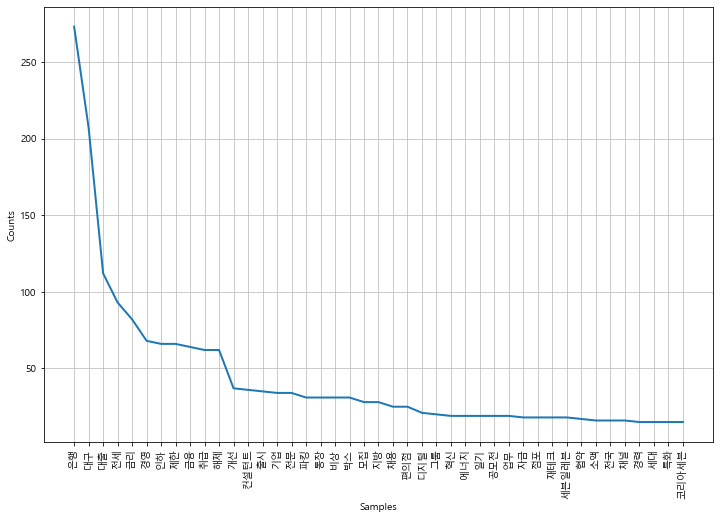

In [147]:
plt.figure(figsize=(12, 8))
ko.plot(idx)
plt.show()

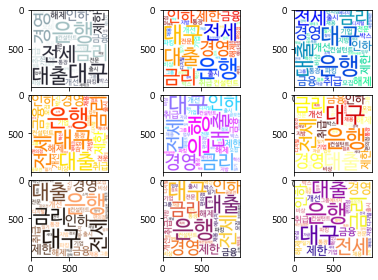

In [228]:
# 색변경 - https://codetorial.net/matplotlib/set_colormap.html
data = ko.vocab().most_common(idx)
palettes = ['bone', 'jet', 'winter','autumn', 'cool', 'hot', 'copper', 'inferno', 'plasma']
fig,ax = plt.subplots(3, 3)
fig.tight_layout()
axes = [ax[0,0],ax[0,1],ax[0,2], ax[1,0],ax[1,1], ax[1,2], ax[2,0], ax[2,1], ax[2,2]]
plt.subplots_adjust(wspace=0.1, 
                    hspace=0.1)

for i in range(9):
    wordcloud = WordCloud(font_path='NanumBarunGothic.ttf',
                          relative_scaling = 0.2,
                          # stopwords=STOPWORDS,
                          background_color='white',
                          width=1000,
                          height=1000,
                          max_words=100,
                          max_font_size=300,
                          colormap = palettes[i]).generate_from_frequencies(dict(data))
    axes[i].imshow(wordcloud)

# plt.figure(figsize=(10, 10))
# plt.imshow(wordcloud)
# plt.axis("off")
# plt.show()

## 최종 결과

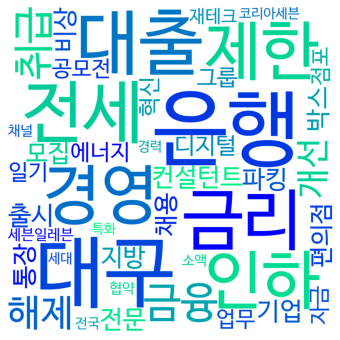

In [223]:
data = ko.vocab().most_common(idx)

wordcloud = WordCloud(font_path='NanumBarunGothic.ttf',
                          relative_scaling = 0.2,
                          background_color='white',
                          width=1000,
                          height=1000,
                          max_words=100,
                          max_font_size=250,
                          colormap = 'winter').generate_from_frequencies(dict(data))
# inferno / jet / copper / cool / winter
plt.figure(figsize=(6,6))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()